### Quantify spillovers from fire treatments

Let's calculate the effect of spillovers on our treatments. Here the treatment is the burn scar and not the low-intensity treatments

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import warnings
from pathlib import Path

import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from prescribed.estimate.calculate_estimator import calculate_spillover_estimator
from prescribed.plot import plot_std_diffs, template_plots
from prescribed.utils import calculate_fire_pop_dens
from tqdm import tqdm

In [3]:
# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Noto Mono"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

In [4]:
pop_zip = list(
    Path("/mnt/sherlock/oak/prescribed_data/raw/population").glob("*.tif")
)
pop_dict = {
    int(p.stem.split("_")[-3]): p
    for p in Path("/mnt/sherlock/oak/prescribed_data/raw/population").glob(
        "*.tif"
    )
}

In [5]:
mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)

mtbs_ca = mtbs[
    (mtbs.Event_ID.str.contains("CA"))
    & (mtbs.Incid_Type.isin(["Wildfire", "Prescribed Fire"]))
].to_crs("3310")
mtbs_ca["Ig_Date"] = pd.to_datetime(mtbs_ca.Ig_Date)
mtbs_ca["year"] = mtbs_ca.Ig_Date.dt.year

# Load California boundaries
ca = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/california_geom/datacalifornia_geom.shp"
).to_crs("4326")

template = rioxarray.open_rasterio(
    "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif"
)

# Add land types
land_type = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather"
)

In [6]:
pop_dens = calculate_fire_pop_dens(
    geoms=mtbs_ca,
    pop_raster_path="/mnt/sherlock/oak/prescribed_data/raw/population",
    mask=ca,
    template=template,
)

Calculating population density...: 100%|██████████| 1886/1886 [00:41<00:00, 45.73it/s]


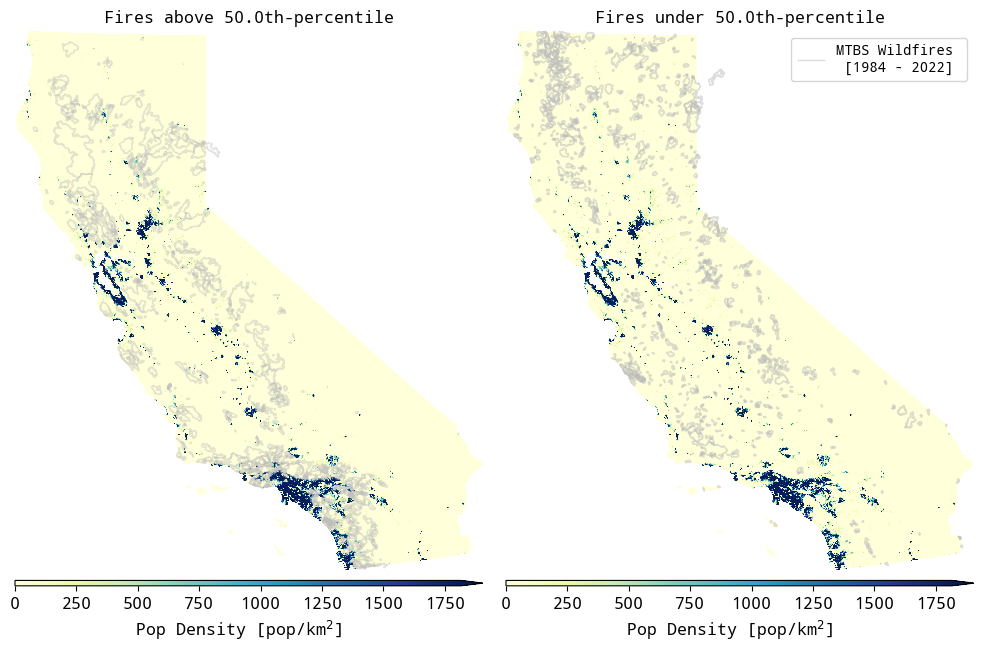

In [7]:
############################# PREPARE DATA FOR PLOT ############################
ds = rioxarray.open_rasterio(pop_dict[2020]).squeeze()

with xr.set_options(keep_attrs=True):
    clip_box = ds.rio.clip_box(*ca.total_bounds)
    cal_pop = clip_box.rio.clip(
        ca.geometry.values, ca.crs, drop=True, invert=False
    ).rio.reproject_match(template)

    cal_pop = xr.where(cal_pop == ds.attrs["_FillValue"], np.nan, cal_pop)
################################################################################


fig, ax = plt.subplots(1, 2, figsize=(10, 12))

thresh_def = 0.50

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("bottom", size="1%", pad=0.1)

cal_pop.plot(
    robust=True,
    ax=ax[0],
    cbar_ax=cax,
    cmap="YlGnBu",
    cbar_kwargs={
        "label": r"Pop Density [pop/km$^2$]",
        "orientation": "horizontal",
    },
)

tresh = pop_dens.total_pop.quantile([thresh_def]).values[0]
subset_events = pop_dens[pop_dens.total_pop >= tresh]

subset_events.geometry.boundary.plot(
    ax=ax[0], color="#bdbdbd", linewidth=1, alpha=0.4
)

template_plots(ax[0], no_axis=True, ylab="", xlab="")

ax[0].set_title(f"Fires above {thresh_def * 100}th-percentile", fontsize=12)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("bottom", size="1%", pad=0.1)

# Low density
cal_pop.plot(
    robust=True,
    ax=ax[1],
    cbar_ax=cax,
    cmap="YlGnBu",
    cbar_kwargs={
        "label": r"Pop Density [pop/km$^2$]",
        "orientation": "horizontal",
    },
)

tresh = pop_dens.total_pop.quantile([thresh_def]).values[0]
subset_events = pop_dens[pop_dens.total_pop <= tresh]

subset_events.geometry.boundary.plot(
    ax=ax[1],
    color="#bdbdbd",
    linewidth=1,
    alpha=0.5,
    label="MTBS Wildfires \n [1984 - 2022]",
)
ax[1].legend(loc="upper right", fontsize=10)

template_plots(ax[1], no_axis=True, ylab="", xlab="")

ax[1].set_title(f"Fires under {thresh_def * 100}th-percentile", fontsize=12)

# Save plot
plt.tight_layout()
# plt.savefig("../figs/pop_density_fires.png", dpi=300)

In [8]:
test_dist = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/distance_treatments/wildfire_distances_20000.feather"
)

<Axes: >

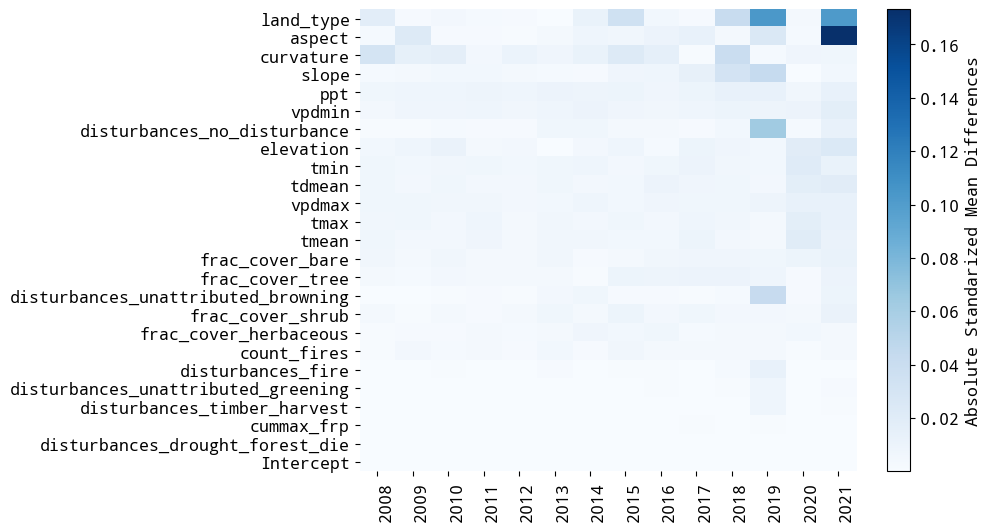

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_std_diffs(
    std_diffs_df="../tyra/treatment_spillovers_2000/best_model_asmd_std_diffs.csv",
    palette="Blues",
    ax=ax,
    draw_cbar=True,
    labels_y=True,
    rotation_x=90,
)

In [97]:
dnbr = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee_inmediate/dnbr_long.feather"
)

# Add years using mtbs data
dnbr = dnbr.merge(
    mtbs_ca[["Event_ID", "year"]], left_on="event_id", right_on="Event_ID"
)
dnbr = dnbr[dnbr.dnbr >= 100] # Just leave stuff that actually burned! 


In [99]:
warnings.simplefilter(action="ignore", category=FutureWarning)

# Load FRP data with nominal confidence and fire with everything where FRP > 0
frp = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/frp_nominal_conf/frp_concat.feather"
).drop(columns=["lat", "lon"])
frp = frp[frp.frp > 0]

# Load treat defniitions
treats_dist = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/distance_treatments/wildfire_distances_20000.feather"
).drop(columns=["lat", "lon", "donut", "wildfire"])

est_dfs_list = []
for distance in [2_000, 5_000, 10_000, 15_000]:
    weights = pd.read_csv(
        f"../tyra/treatment_spillovers_{distance}/best_model_asmd_weights.csv"
    )

    df = calculate_spillover_estimator(
        treatments=treats_dist,
        weights=weights,
        fire_data=dnbr,
        #focal_years=np.arange(2008, 2023),
        focal_years=np.arange(2008, 2021),
        distance=distance,
        estimator="att",
        dep_var="dnbr",
        pooling=True,
        cluster_var="year",
        formula="att ~ lag",
        freq_weights="control_mean",
        max_lags=12,
        rr=False,
    )

    est_dfs_list.append(df)


df = pd.concat(est_dfs_list)


Calculate estimate for focal year: 100%|██████████| 13/13 [00:00<00:00, 34.40it/s]


/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/p

<Axes: >

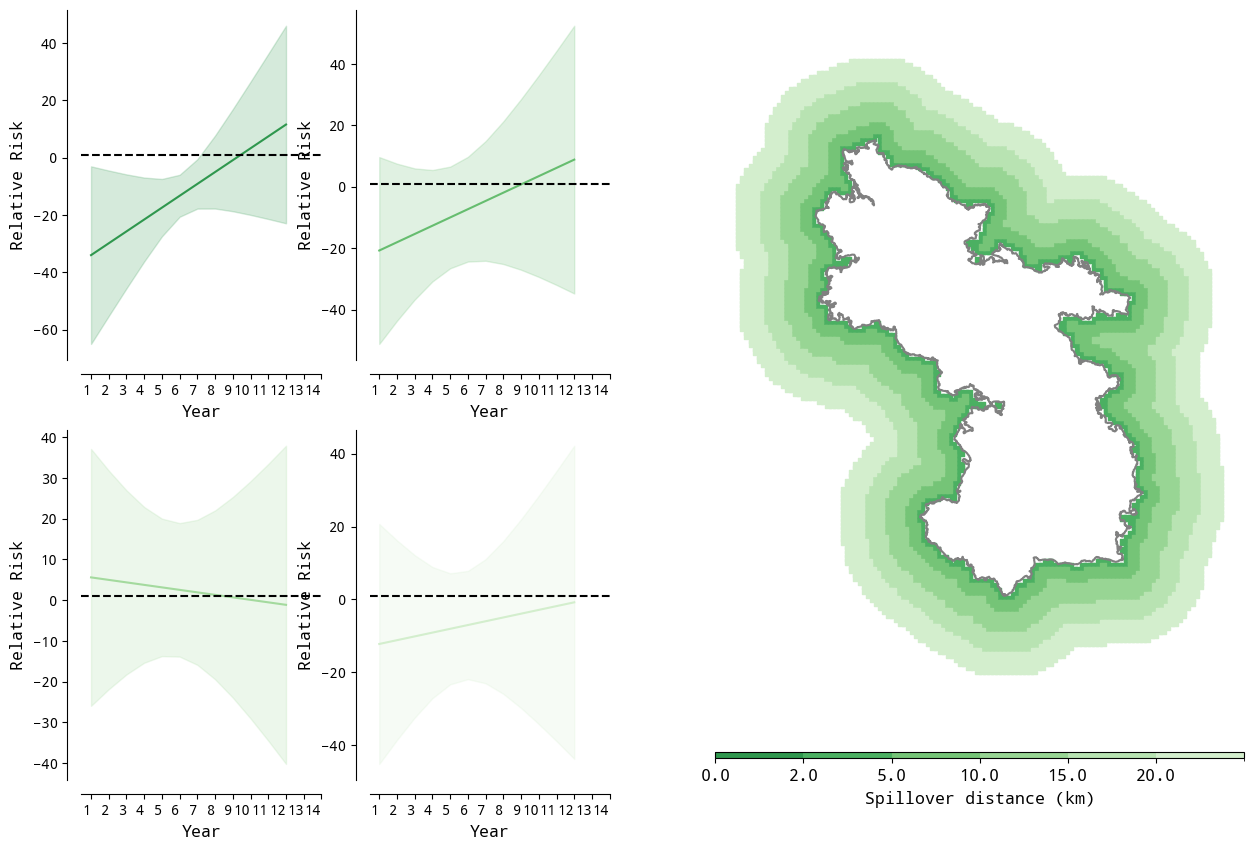

In [100]:
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.gridspec import GridSpecFromSubplotSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

num_colors = len(df.dist_treat.unique())
green_colors = cm.Greens_r(np.linspace(0.3, 0.8, num_colors))

# Plot coefs and CIs for the different high classes and land types
fig = plt.figure(figsize=(15, 10))
spec = fig.add_gridspec(1, 2)

subspec = GridSpecFromSubplotSpec(2, 2, subplot_spec=spec[0, 0])

for idx, dist in enumerate(df.dist_treat.unique()):
    ax = fig.add_subplot(subspec[idx])

    data = df[df.dist_treat == dist]
    data = data.sort_values("year")
    data.plot(
        x="year",
        y="coef",
        ax=ax,
        color=green_colors[idx],
        legend=False,
    )

    ax.fill_between(
        data.year,
        data.low_ci,
        data.high_ci,
        alpha=0.2,
        color=green_colors[idx],
    )

    ax.axhline(1, color="black", linestyle="--")

    # Chage x-axis ticks to go from 1 to 9
    ax.set_xticks(range(1, 15))
    ax.set_xticklabels(range(1, 15))

    #ax.set_ylim([0, 2])
    #ax.set_yticks(np.arange(0, 2.1, 0.5))
    #ax.set_yticklabels(np.arange(0, 2.1, 0.5))

    template_plots(ax, xlab="Year", ylab="Relative Risk")

#################### PLOT MAP ####################
event_id = "CA3966012280920200817"
dists = [0, 2_000, 5_000, 10_000, 15_000, 20_000]

num_colors = len(dists)
green_colors = cm.Greens_r(np.linspace(0.3, 0.8, num_colors))

# Create separate DataFrames for each distance range
df_dists = []
for i in range(len(dists)):
    if i == 0:
        df_d = test_dist[
            (test_dist.donut == event_id)
            & (test_dist.distance < dists[i])
            & (test_dist.distance > 0)
        ]
    else:
        df_d = test_dist[
            (test_dist.donut == event_id)
            & (test_dist.distance < dists[i])
            & (test_dist.distance >= dists[i - 1])
        ]
    df_dists.append(df_d)

# Plot each distance range with a different color
ax = fig.add_subplot(spec[0, 1])

for idx, df_d in enumerate(df_dists):
    df_d.plot.scatter(
        x="lon", y="lat", ax=ax, color=green_colors[idx], marker=","
    )

# Plot the fire perimeter
mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax, color="gray")

# Create a color axis (cax) below the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="1%", pad=0.5)

# Create a ListedColormap and BoundaryNorm
cmap = ListedColormap(green_colors)
norm = BoundaryNorm(dists + [dists[-1] + 1], cmap.N)

# Add a colorbar
cb = fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation="horizontal"
)
cb.set_label("Spillover distance (km)")
cb.set_ticks(dists)
cb.set_ticklabels([f"{dist/1000}" for dist in dists])

# Format the plot
template_plots(
    ax, no_axis=True, ylab="", xlab="", label_pos=(-0.1, 1.24)
)
#plt.savefig("../figs/spillover_coefficients.png", dpi=300)